<a href="https://colab.research.google.com/github/omkarsk98/NewsDataClassification/blob/development/NewsDataClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the repo for original and raw csv data

In [107]:
# !git clone https://github.com/omkarsk98/NewsDataClassification.git

Go the directory and checkout to the required folder

In [108]:
# %cd NewsDataClassification
# !git checkout development

Download trained model and unzip it.

In [109]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !gunzip GoogleNews-vectors-negative300.bin.gz

Download nltk libraries and dependencies

In [110]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from gensim import downloader
from keras import layers, models, backend

[nltk_data] Downloading package punkt to /Users/kullya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kullya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


import all required libraries

In [111]:
import pandas as pd
# from gensim import models
from sklearn.linear_model import LogisticRegression
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score ,confusion_matrix
import time
from sklearn.manifold import TSNE
# from google.colab import files

In [112]:
# Load word2vec model (trained on Google's corpus)
model = downloader.load('word2vec-google-news-300')
# model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 
# Check dimension of word vectors
print("Dimensions of the model",model.vector_size)

Dimensions of the model 300


Read the raw data and set max records to be used

In [113]:
# read csv
main_data = pd.read_csv('News_Final.csv')

# read titles from it
article_titles = main_data['TITLE']
labels = main_data["CATEGORY"]

# Create a list of strings, one for each title
titles_list = [title for title in article_titles]
# form a single string fro the list of strings
big_title_string = ' '.join(titles_list)

# define total records to be considered for analysis
total = 50000
# 422178 total records as max value

/var/folders/6q/k6zt03hn645cnsdj26f8d44h0000gn/T/ipykernel_23998/3374548816.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  main_data = pd.read_csv('News_Final.csv')


Tokenise all words and get stop words for english

In [114]:
# Tokenize the string into words
tokens = word_tokenize(big_title_string)

# Remove non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()]
stop_words = set(stopwords.words('english'))

Define all the function that can be used for later stage

In [115]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model for word in doc)

# Filter out documents
def filter_docs(corpus, texts, labels, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which takes a doc. The document doc is kept if condition_on_doc(doc) is true.
    """
    number_of_docs = len(corpus)
    
    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus)
                 if condition_on_doc(doc)]
    

    corpus = [doc for doc in corpus if condition_on_doc(doc)]
    
    final_labels = []
    for i in range(len(corpus)):
      if condition_on_doc(corpus[i]):
        final_labels.append(labels[i])
    
    print("{} docs removed".format(number_of_docs - len(corpus)))

    return (corpus, texts, final_labels)

Remove stop words, non vocab words, empty docs and prepare vector for each title

In [116]:
# # Preprocess the corpus to get list of documents with stop words removed and containing only the words that are present in the vocab
corpus = [preprocess(title) for title in titles_list]
# # still contains all the documents, nothing is filtered

# # Remove docs that don't include any words in W2V's vocab
corpus, titles_list, labels = filter_docs(corpus, titles_list, labels, lambda doc: has_vector_representation(model, doc))
print("1st filter: Length of corpus:"+str(len(corpus))+", Length of titles_list:"+ str(len(titles_list))+", Length of labels:"+str(len(labels)))

# # Filter out any empty docs
corpus, titles_list, labels = filter_docs(corpus, titles_list, labels, lambda doc: (len(doc) != 0))
print("2nd filter: Length of corpus:"+str(len(corpus))+", Length of titles_list:"+ str(len(titles_list))+", Length of labels:"+str(len(labels)))

x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))

240 docs removed
1st filter: Length of corpus:422179, Length of titles_list:422179, Length of labels:422179
0 docs removed
2nd filter: Length of corpus:422179, Length of titles_list:422179, Length of labels:422179


# **After removing stop words and empty docs** <br>

---
241 docs removed <br>
1st filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178 <br>
0 docs removed <br>
2nd filter: Length of corpus:422178, Length of titles_list:422178, Length of labels:422178 <br>

In [117]:
vectorsForEachDocument = np.array(x) # list to array
labels = np.array(labels)
labels = labels.reshape(labels.shape[0],1)
vectorsForEachDocument.shape, labels.shape

((422179, 300), (422179, 1))

# **Vectors for each title** 

---
A list of vectors of 300 dimensions each for all the titles and labels contain the respective labels<br>
Shape of these vectors is (422178, 300) <br>
Shape pf it respective labels (422178, 1)

# **Filter improper labels**

---
Filter out the data that has improper labels. Labels should only be of the following types. <br>
1. b: business
2. t: technology
3. e: entertainment
4. m: health

In [118]:
# filter out data that has improper labels
possibleLabels = ["b","t","e","m"]
finalLabels = []
features = []
for i in range(len(labels)):
  if labels[i] in possibleLabels:
    finalLabels.append(labels[i])
    features.append(vectorsForEachDocument[i])
  if(len(finalLabels)==total):
    break


features = np.array(features)
labels = np.array(finalLabels)
labels = labels.reshape(labels.shape[0],1)
features.shape, labels.shape

((50000, 300), (50000, 1))

# **Create a dataframe to shuffle it**

---
Create dataframe to shuffle it and split it.

In [119]:
finalData = pd.DataFrame.from_records(features)
finalData.columns = range(1,301)
finalData["labels"] = labels
# finalData.to_csv('FinalData.csv')
data = finalData.sample(frac=1) #shuffles the data
labels = data["labels"]
labels = np.array(labels) 
labels = labels.reshape(labels.shape[0],1)
del data["labels"]
features = np.array(data)
features.shape, labels.shape

((50000, 300), (50000, 1))

# Split the data
---
**Train Data**: Use 80% of the data for training purpose. <br>
**Test Data**: Use 20% of the data for testing purpose. <br>
**Features**: Use 300 dimensional vectors as features. It can be found in `vectorsForEachDocument`.<br>
**Labels**: Use the categories as labels. I can be found in `labels`.<br>

In [120]:
train = int((80/100)*len(features))
trainFeatures, testFeatures = features[:train], features[train:]
trainLabels, testLabels = labels[:train], labels[train:]
trainFeatures.shape, trainLabels.shape, testFeatures.shape, testLabels.shape

((40000, 300), (40000, 1), (10000, 300), (10000, 1))

**Shapes of the data** <br>
trainFeatures: (160000,300) <br>
trainLabels: (160000,1) <br>
testFeatures: (40000,300) <br>
testLabels: (40000,1) <br>

# **Train the logistic regression model** <br>

In [121]:
tic = time.time()
logistic_Regression = LogisticRegression(multi_class="auto", solver="lbfgs", max_iter=1000)
logistic_Regression.fit(trainFeatures,trainLabels)
Y_predict = logistic_Regression.predict(testFeatures)
print(str((accuracy_score(testLabels,Y_predict)*100))+"%")
toc = time.time()
print("Time taken: "+str(round(toc - tic, 4))+" seconds")

/Users/kullya/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


85.44%
Time taken: 5.9677 seconds


# **Outcomes of the training** <br>

---
|Train |Test |Dimensions |Accuracy |Time(sec) | Comments |
|---|---|---|---|---|---|
|40000|10000|300|86|12|Data randomly shuffled|
|80000|20000|300|78|53||
|40000|10000|300|74|12||
|80000|20000|300|78|53||
|24000|6000|300|73|11||
|160000|40000|300|72|53||


**Precision and recall**

---
Calculating precision and recall using sklearn.metrics.precision_recall_fscore_support.<br>
Precision is the fraction of relevant instances among the retrieved instances, while recall is the fraction of the total amount of relevant instances that were actually retrieved.



In [122]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(testLabels, Y_predict, labels=possibleLabels)
print("For labels in sequence as", possibleLabels)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))

For labels in sequence as ['b', 't', 'e', 'm']
precision: [0.82423652 0.82466997 0.89775706 0.86948357]
recall: [0.85478437 0.79514718 0.91617122 0.80242634]


**Result of precision and recall**

---

For labels in sequence as ['b', 't', 'e', 'm'] <br>
precision: [82.94729775 83.25883787 89.44781729 87.46594005] <br>
recall: [84.79752917 80.92417062 91.4843288  82.16723549] <br>

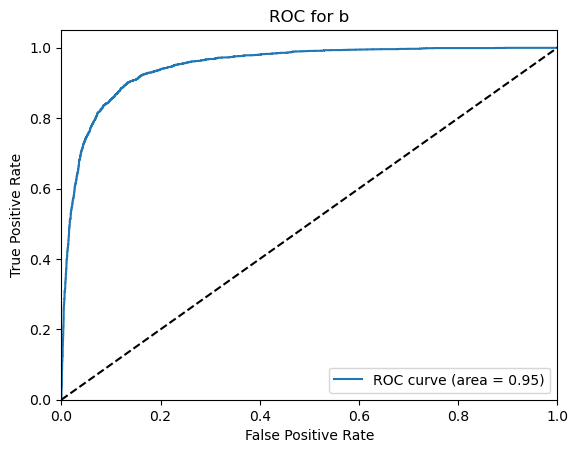

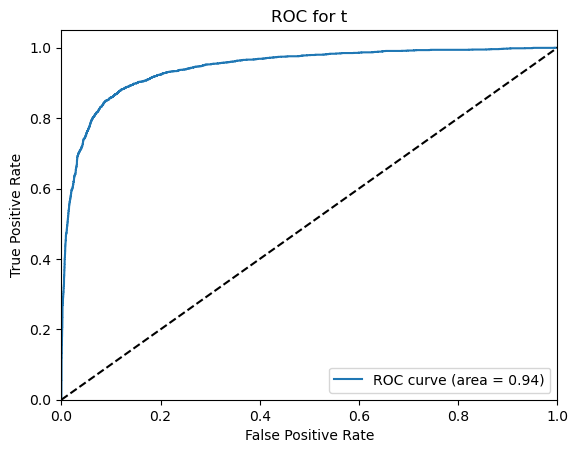

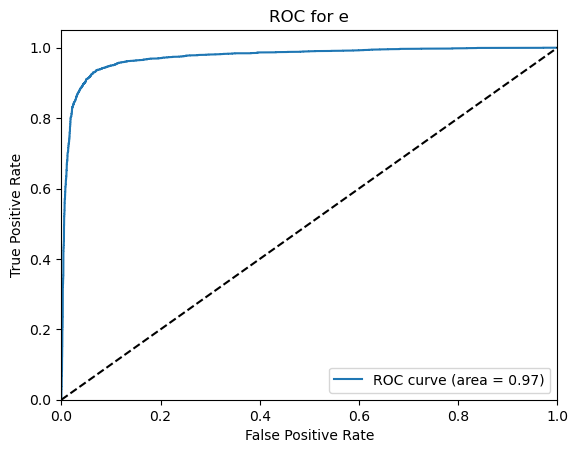

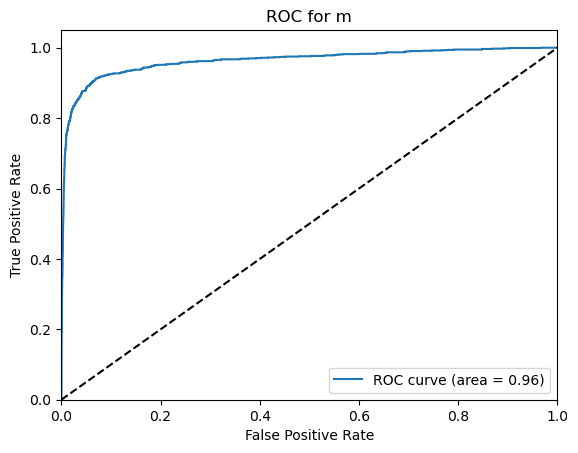

In [123]:
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

testLabelsBinary = label_binarize(testLabels, classes=possibleLabels)
trainLabelsBinary = label_binarize(trainLabels, classes=possibleLabels)

# classifier
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
y_score = clf.fit(trainFeatures, trainLabelsBinary).decision_function(testFeatures)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(testLabelsBinary[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(4):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = 'ROC for '+possibleLabels[i]
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


# Neural Network
---
One hot encode labels

In [124]:
trainLabelsTags = {"b":0, "t":1, "e":2, "m":3}
trainLabels = np.reshape(trainLabels, trainLabels.shape[0])
testLabels = np.reshape(testLabels, testLabels.shape[0])
print("trainLabels:", trainLabels.shape)
print("testLabels:", testLabels.shape)
trainLabels = np.array([trainLabelsTags[tag[0]] for tag in trainLabels])
testLabels = np.array([trainLabelsTags[tag] for tag in testLabels])

trainLabels: (40000,)
testLabels: (10000,)


In [125]:
# trainLabels
# testLabels

In [126]:
trainLabelsEncoded = np.zeros((len(trainLabels), 4))
print("trainLabels.size:", trainLabelsEncoded.size, trainLabelsEncoded.shape)
trainLabelsEncoded[np.arange(trainLabelsEncoded.shape[0]), trainLabels] = 1

testLabelsEncoded = np.zeros((len(testLabels), 4))
testLabelsEncoded[np.arange(testLabelsEncoded.shape[0]), testLabels] = 1

print("trainLabelsEncoded:", trainLabelsEncoded)
print("testLabelsEncoded:", testLabelsEncoded)

trainLabels.size: 160000 (40000, 4)
trainLabelsEncoded: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]
testLabelsEncoded: [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [127]:
avgFNN = models.Sequential()
avgFNN.add(layers.Input(shape = 300))
avgFNN.add(layers.Dense(100, activation = "relu"))
avgFNN.add(layers.Dense(50, activation = "relu"))
avgFNN.add(layers.Dense(4, activation = "softmax"))

avgFNN.summary()
avgFNN.compile(optimizer = "adam", metrics = ["accuracy"], loss = "categorical_crossentropy")

avgFNN.fit(trainFeatures, trainLabelsEncoded, batch_size = 64, epochs = 10)
# print("++++++++++++++++++++++++++++++++++++++\nDone training!!!!!!!!!!!!!!!!!!\n++++++++++++++++++++++++++++++++++++++")
predictedLabels = avgFNN.evaluate(testFeatures, testLabelsEncoded)
print("Accuracy: "+str(round(predictedLabels[1], 4) * 100)+"%")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               30100     
                                                                 
 dense_31 (Dense)            (None, 50)                5050      
                                                                 
 dense_32 (Dense)            (None, 4)                 204       
                                                                 
Total params: 35,354
Trainable params: 35,354
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
  6/625 [..............................] - ETA: 7s - loss: 1.3498 - accuracy: 0.3151  

2022-10-16 18:22:44.464873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 6s 9ms/step - loss: 0.5012 - accuracy: 0.8271
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3599 - accuracy: 0.8789
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3050 - accuracy: 0.8983
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2615 - accuracy: 0.9136
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2285 - accuracy: 0.9243
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2024 - accuracy: 0.9322
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.1794 - accuracy: 0.9397
Epoch 8/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1593 - accuracy: 0.9468
Epoch 9/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1431 - accuracy: 0.9519
Epoch 10/10
 15/313 [>.............................] - ETA: 2s - loss: 0.2986 - accuracy: 0.9083

2022-10-16 18:23:43.644112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 8ms/step - loss: 0.3103 - accuracy: 0.9094
Accuracy: 90.94%


# **Outcomes of the training on Neural Network** <br>

---
|Train |Test |Dimensions |Accuracy |Time(sec) | Comments |
|---|---|---|---|---|---|
|40000|10000|300|90.9|73||


In [128]:
rnnTrainFeatures = np.reshape(trainFeatures, (trainFeatures.shape[0], 1, trainFeatures.shape[1]))
rnnTestFeatures = np.reshape(testFeatures, (testFeatures.shape[0], 1, testFeatures.shape[1]))

network = models.Sequential()
network.add(layers.SimpleRNN(20,  input_shape=(None,rnnTrainFeatures.shape[2]),activation='relu'))
network.add(layers.Dense(100, activation = "relu"))
network.add(layers.Dense(50, activation = "relu"))
network.add(layers.Dense(4, activation = "softmax"))

# network.summary()
network.compile(optimizer = "adam", metrics = ["accuracy"], loss = "categorical_crossentropy")

network.fit(rnnTrainFeatures, trainLabelsEncoded, epochs = 10, batch_size = 64)
predictedLabels = network.evaluate(rnnTestFeatures, testLabelsEncoded)
print("Accuracy: "+str(round(predictedLabels[1], 4) * 100)+"%")

Epoch 1/10


2022-10-16 18:23:46.866204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 10s 16ms/step - loss: 0.5376 - accuracy: 0.8101
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3982 - accuracy: 0.8602
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.3686 - accuracy: 0.8747
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.3446 - accuracy: 0.8828
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3234 - accuracy: 0.8917
Epoch 6/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3079 - accuracy: 0.8967
Epoch 7/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2931 - accuracy: 0.9034
Epoch 8/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2796 - accuracy: 0.9077
Epoch 9/10
625/625 [==============================] - 9s 15ms/step - loss: 0.2684 - accuracy: 0.9107
Epoch 10/10
  6/313 [..............................] - ETA: 3s - loss: 0.3030 - accuracy: 0.8854  

2022-10-16 18:25:23.424538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 4s 11ms/step - loss: 0.3451 - accuracy: 0.8856
Accuracy: 88.56%


# **Outcomes of the training on Recurrent Neural Network** <br>

---
|Train |Test |Dimensions |Accuracy |Time(sec) | Comments |
|---|---|---|---|---|---|
|40000|10000|300|88.63|96||
